# TensorFlow for Deep Learning - U-Net for Semantic Segmentation

Credits - [U-Net for Semantic Segmentation](https://www.youtube.com/playlist?list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE/)

<img src="images/TF_UNet1.png" width="700"/>
<img src="images/TF_UNet3.png" width="700"/>


## Data Processing

In [18]:
import os
import numpy as np
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

np.random.seed = 42

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'data/data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data/data-science-bowl-2018/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, name in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + name
    img = imread(path + '/images/' + name + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
    Y_train[n] = mask  

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Resizing testing images')
for n, name in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + name
    img = imread(path + '/images/' + name + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing training images and masks


100%|██████████| 670/670 [06:06<00:00,  1.83it/s]


Resizing testing images


100%|██████████| 65/65 [00:02<00:00, 26.53it/s]


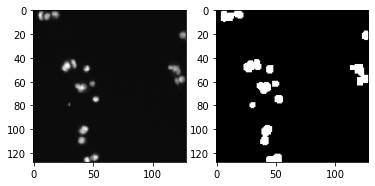

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(X_train[10])
ax[1].imshow(Y_train[10], cmap='gray');

## U-Net Model

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Lambda, Dropout

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = Lambda(lambda x: x/255.)(inputs)

# Contraction Path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c1')(c1)
p1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c2')(c2)
p2 = MaxPool2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c3')(c3)
p3 = MaxPool2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c4')(c4)
p4 = MaxPool2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c5')(c5)

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c6')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c7')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c8')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c9')(c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_10[0][0]                  
____________________________________________________________________________________________

In [25]:
import tensorflow.keras.callbacks as cbs

callbacks = [cbs.ModelCheckpoint('modules/model_for_nuclei.h5', save_best_only=True),
             cbs.EarlyStopping(patience=2, monitor='val_loss')]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 7s 116ms/step - loss: 0.1408 - accuracy: 0.9462 - val_loss: 0.1232 - val_accuracy: 0.9541
Epoch 2/25
38/38 [==============================] - 4s 105ms/step - loss: 0.1219 - accuracy: 0.9525 - val_loss: 0.1102 - val_accuracy: 0.9598
Epoch 3/25
38/38 [==============================] - 4s 106ms/step - loss: 0.1069 - accuracy: 0.9579 - val_loss: 0.1127 - val_accuracy: 0.9596
Epoch 4/25
38/38 [==============================] - 4s 105ms/step - loss: 0.1051 - accuracy: 0.9596 - val_loss: 0.1052 - val_accuracy: 0.9623
Epoch 5/25
38/38 [==============================] - 4s 105ms/step - loss: 0.1036 - accuracy: 0.9609 - val_loss: 0.1004 - val_accuracy: 0.9626
Epoch 6/25
38/38 [==============================] - 4s 104ms/step - loss: 0.0934 - accuracy: 0.9640 - val_loss: 0.1006 - val_accuracy: 0.9628
Epoch 7/25
38/38 [==============================] - 4s 105ms/step - loss: 0.0930 - accuracy: 0.9643 - val_loss: 0.0983 - val_accuracy: 0.9611
Epoch 

In [ ]:
idx = np.random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

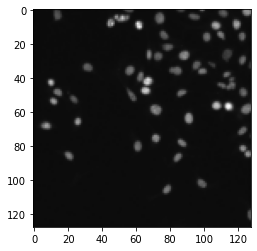

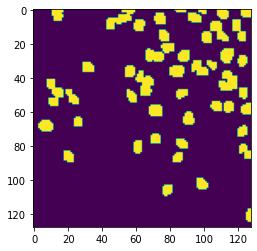

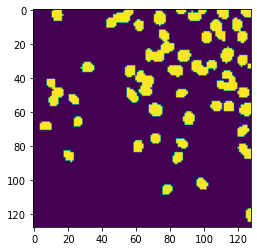

In [50]:
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()